In [2]:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import norm
    from datetime import datetime, timedelta

    %matplotlib inline

## Import Raw Data

In [3]:
data = pd.read_csv('uvxy.csv')
#print(data.shape)

data['date'] = pd.to_datetime( data['date'] )
data['expiration'] = pd.to_datetime( data['expiration'] )

#print(data.head())

1) Pandas imports the date fileds as strings.  We need to turn them into datetime objects.<br>
2)  We the prune out the lines that have zero bid or trade less then ten contracts per day.<br>
3) We need the time from the trade date to expiration in years.  We calculate than then store it in the column named 't'

In [4]:
df = data[ data['expiration'] == pd.to_datetime('2014-09-20 00:00:00') ]
df = df[ df['volume'] > 10]
df = df[ df['bid'] > 0]
print(df.shape)
df['t'] = (df['expiration'] - df['date'] - timedelta(days = 1)) / timedelta(days=1) / 365

(3925, 14)


For the sake of simplicty, we also split calls and puts into their own data frames.

In [5]:
call = df[ df['call/put'] == 'C']
put  = df [df['call/put'] == 'P']

Our code needs the data in numpy format.  We extract them directly from the frames.

In [6]:
t_call = call['t'].to_numpy()
K_call = call['strike'].to_numpy()
S_call = call['unadjusted stock price'].to_numpy()
r_call = 0.1 * np.ones( S_call.shape )
ask_call = call['ask'].to_numpy()
bid_call = call['bid'].to_numpy()

t_put = put['t'].to_numpy()
K_put = put['strike'].to_numpy()
S_put = put['unadjusted stock price'].to_numpy()
r_put  = 0.1 * np.ones( S_put.shape )
ask_put = put['ask'].to_numpy()
bid_put = put['bid'].to_numpy()

##  Black Scholes Model

In [7]:
def call_price(sigma, S, K, r, t):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    C = np.multiply(S, norm.cdf(d1)) - \
        np.multiply(norm.cdf(d2) * K, np.exp(-r * t))
    return C

def put_price(sigma, S, K, r, t):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    P = -np.multiply(S, norm.cdf(-d1)) + \
        np.multiply(norm.cdf(-d2) * K, np.exp(-r * t))
    return P

def call_objective_function(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    price = args[4]
    
    return call_price(sigma, S, K, r, t) - price

def put_objective_function(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    price = args[4]
    
    return put_price(sigma, S, K, r, t) - price

def calculate_vega(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    return S * norm.pdf(d1) * np.sqrt(t)


#  This function searches the data for contracts that don't have roots
def find_no_root(f, args):
    f_value = f( np.array(0), args)
    return np.where(f_value > 0)

Search for contracts that don't have a root, then remove them from our data set.

In [8]:
call_args = (S_call, K_call, r_call, t_call, ask_call)
put_args = (S_put, K_put, r_put, t_put, ask_put)

ind = find_no_root(call_objective_function, call_args)
ind = ind[0]

t_call = np.delete(t_call, ind)
K_call = np.delete(K_call, ind)
S_call = np.delete(S_call, ind)
r_call = np.delete(r_call, ind)
ask_call = np.delete(ask_call, ind)
bid_call = np.delete(bid_call, ind)

C:\Users\moone\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Our Newton's code.  In the case of vectorized data, we use the infinity mean as a cutoff criteria.

In [9]:
def newtons_method(f, fprime, R = 0, max_iter = 1000, tol=1e-3, args = [], debug = False):
    count = 0
    epsilon = 1
    f_return = []
    fprime_return = []
    
    while epsilon >= tol:
        count += 1
        if count >= max_iter:
            print('Exiting on runaway loop.')
            return (R, count)
        
        old_R = R
        
        function_value = f(R, args = args)
        function_derivative = fprime(R, args = args)
        ind = np.where(function_derivative <= 0)
        ind = ind[0]
       
        R = -function_value / function_derivative + R
        
        if ind.size > 0:
            R[ ind ] = R[ ind ] * 0.5 + R[ ind ]
            
        if np.isscalar(R):
            epsilon = np.abs( (R - old_R) /old_R )
        else:
            epsilon = np.linalg.norm( R - old_R, np.Inf)
        
        if debug == True:
            f_return.append(function_value)
            fprime_return.append(function_derivative)
        
    return R, count, epsilon, function_value, function_derivative, f_return, fprime_return

Run the code on the call data

In [10]:
call_args = (S_call, K_call, r_call, t_call, ask_call)
put_args = (S_put, K_put, r_put, t_put, ask_put)
vol, iter, error, f, vega, F, FP = newtons_method(call_objective_function, calculate_vega, R = 3, args = call_args, debug = False)

C:\Users\moone\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\moone\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\moone\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\moone\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\Users\moone\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\moone\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
C:\Users\moone\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered

We search for points that didn't give an answer, gave a negative value, or an infinity.  We remove those.

In [11]:
ind1 = np.where(vol == np.inf)
print(ind1[0])

ind2 = np.where( np.isnan(vol) )
print(ind2[0])

ind3 = np.where(vol > 20)
print(ind3[0])
#plt.plot(vol)

[17]
[2414 2415 2416 2417 2418 2419 2420]
[  6  14  15  16  17  18  30  52  53 219 362 385 411 439]


C:\Users\moone\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [12]:
vol = np.delete(vol, np.hstack( (ind1, ind2, ind3)) )

(-0.5, 4.0)

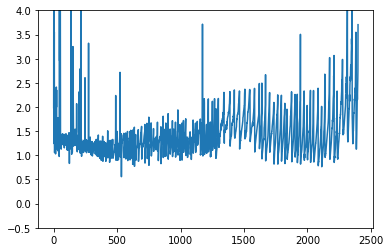

In [13]:
#  Visualize the results
plt.plot(vol)
plt.ylim([-0.5, 4] )